# Uber Pickups

In [1]:
!pip install statsmodels

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import DBSCAN

In [6]:
# Loading dataset

apr14 = pd.read_csv('Dataset-files/uber-raw-data-apr14.csv')
may14 = pd.read_csv('Dataset-files/uber-raw-data-may14.csv')
jun14 = pd.read_csv('Dataset-files/uber-raw-data-jun14.csv')
jul14 = pd.read_csv('Dataset-files/uber-raw-data-jul14.csv')
aug14 = pd.read_csv('Dataset-files/uber-raw-data-aug14.csv')
sep14 = pd.read_csv('Dataset-files/uber-raw-data-sep14.csv')

df_14 = pd.concat([apr14, may14,jun14,jul14,aug14,sep14], ignore_index = True)
df_14.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [7]:
# Returning the type data of each column
df_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 138.4+ MB


In [8]:
# Returning the percentage of missing values for each column
display(100*df_14.isnull().sum()/df_14.shape[0])

Date/Time    0.0
Lat          0.0
Lon          0.0
Base         0.0
dtype: float64

In [9]:
# Converting Date/Time column to datetime type and expanding it to seperate columns

df_14['Date/Time'] = pd.to_datetime(df_14['Date/Time'])
df_14['Date'] = df_14['Date/Time'].dt.date
df_14['Month'] = df_14['Date/Time'].dt.month
df_14['Week'] = df_14['Date/Time'].dt.week
df_14['Time'] = df_14['Date/Time'].dt.hour
df_14['Num_Day'] = df_14['Date/Time'].dt.dayofweek 

#On 'DayofWeekNum': 0 = Monday, 1=Tuesday, ..., 6 = Sunday
df_14['Day'] = df_14['Date/Time'].dt.day_name() 
df_14.head()

<ipython-input-9-f6c2bbf3c774>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_14['Week'] = df_14['Date/Time'].dt.week


,Date/Time,Lat,Lon,Base,Date,Month,Week,Time,Num_Day,Day
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014-04-01,4,14,0,1,Tuesday
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014-04-01,4,14,0,1,Tuesday
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014-04-01,4,14,0,1,Tuesday
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014-04-01,4,14,0,1,Tuesday
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014-04-01,4,14,0,1,Tuesday


# Exploratory Analysis

C:\Users\elena\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


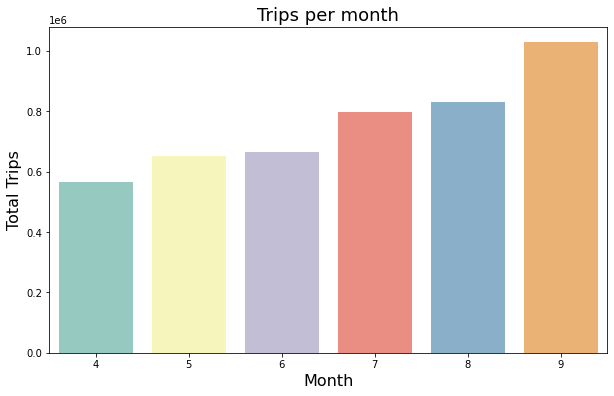

In [10]:
# counting rides for each month for all base
monthly_rides = df_14['Base'].groupby(df_14['Month']).count() 

plt.figure(figsize=(10,6))
sns.barplot(monthly_rides.index, monthly_rides.values, palette='Set3')

plt.title('Trips per month', fontsize=18)
plt.ylabel('Total Trips', fontsize=16)
plt.xlabel('Month', fontsize=16)
#plt.legend(['Base'])
plt.show()

C:\Users\elena\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


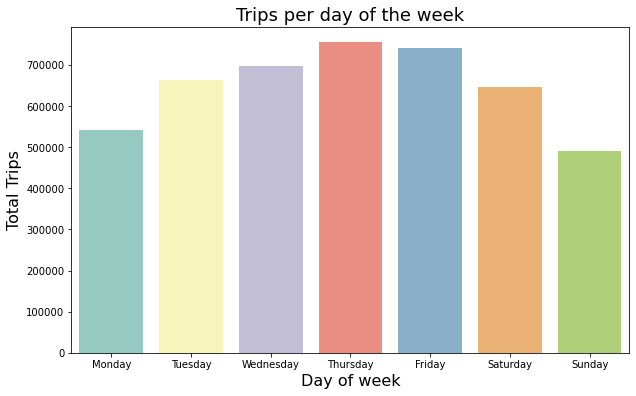

In [11]:
# counting rides for each week for all bases

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
monthly_rides = df_14['Base'].groupby(df_14['Day']).count().reindex(order) 

plt.figure(figsize=(10,6))
sns.barplot(monthly_rides.index, monthly_rides.values, palette='Set3')

plt.title('Trips per day of the week', fontsize=18)
plt.ylabel('Total Trips', fontsize=16)
plt.xlabel('Day of week', fontsize=16)
plt.show()

Interestingly, there were more rides on Thursday! Friday closely followed. There were more rides on even Wednesday and Tuesday than on Saturdays, which was not what I expected!

We will try to visualise the number of rides for the weekdays for each months.

In [12]:
daily_rides_month = df_14.groupby(['Month', 'Num_Day','Day'])['Base'].count()
daily_rides_month = daily_rides_month.reset_index()
daily_rides_month = daily_rides_month.rename(columns = {'Base':'Rides'})

daily_rides_month.head(20)

,Month,Num_Day,Day,Rides
0,4,0,Monday,60861
1,4,1,Tuesday,91185
2,4,2,Wednesday,108631
3,4,3,Thursday,85067
4,4,4,Friday,90303
5,4,5,Saturday,77218
6,4,6,Sunday,51251
7,5,0,Monday,63846
8,5,1,Tuesday,76662
9,5,2,Wednesday,89857


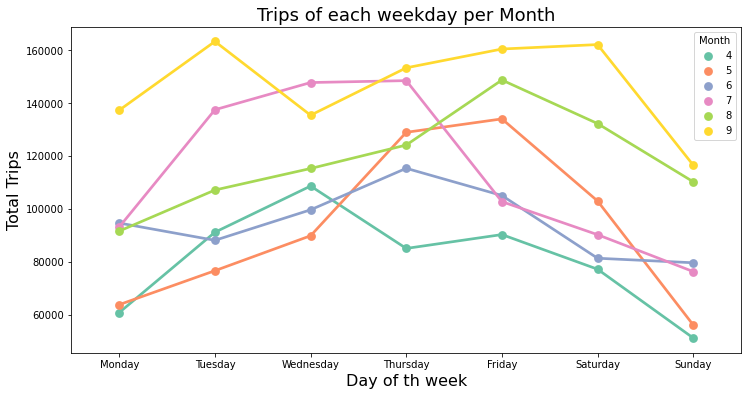

In [13]:
fig = plt.figure(figsize= (12,6))

sns.pointplot(x = 'Day', y = 'Rides', hue = 'Month', data = daily_rides_month, palette='Set2')

plt.title('Trips of each weekday per Month', fontsize=18)
plt.ylabel('Total Trips', fontsize=16)
plt.xlabel('Day of th week', fontsize=16)
plt.show()


From the plot above, we can see how the number of Uber pickups increasing each month, with Thursday having more pickups. We can also view the total pickups for each day of the individual months and as you can clearly notice, the line graphs all seem to have a similar pattern to some extent throughout the week. Breaking down the data also shows us that only July and August had the highest total number of pickups on Thursdays.

C:\Users\elena\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


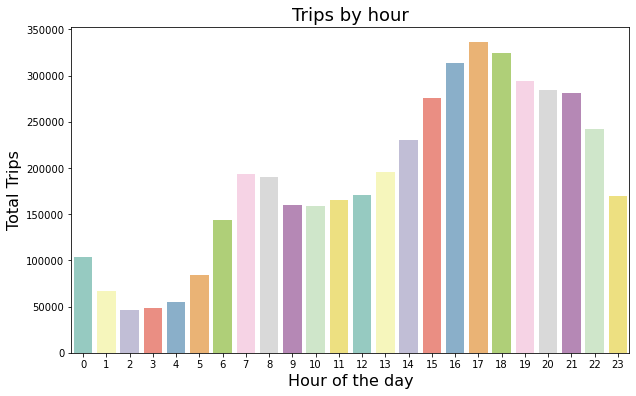

In [14]:
# counting rides for each hour
monthly_rides = df_14['Base'].groupby(df_14['Time']).count() 

plt.figure(figsize=(10,6))
sns.barplot(monthly_rides.index, monthly_rides.values, palette='Set3')

plt.title('Trips by hour', fontsize=18)
plt.ylabel('Total Trips', fontsize=16)
plt.xlabel('Hour of the day', fontsize=16)
#plt.legend(['Base'])
plt.show()

Looks like the demand for Uber increases between 6:00 – 8:00 and then again even more from 15:00. Rises until 17:00 and then steadily starts decreasing until late night.

In [15]:
hourly_rides = df_14.groupby(['Month', 'Num_Day','Day', 'Time'])['Base'].count()
hourly_rides = hourly_rides.reset_index()
hourly_rides = hourly_rides.rename(columns = {'Base':'Rides'})

hourly_rides.head()

,Month,Num_Day,Day,Time,Rides
0,4,0,Monday,0,518
1,4,0,Monday,1,261
2,4,0,Monday,2,238
3,4,0,Monday,3,571
4,4,0,Monday,4,1021


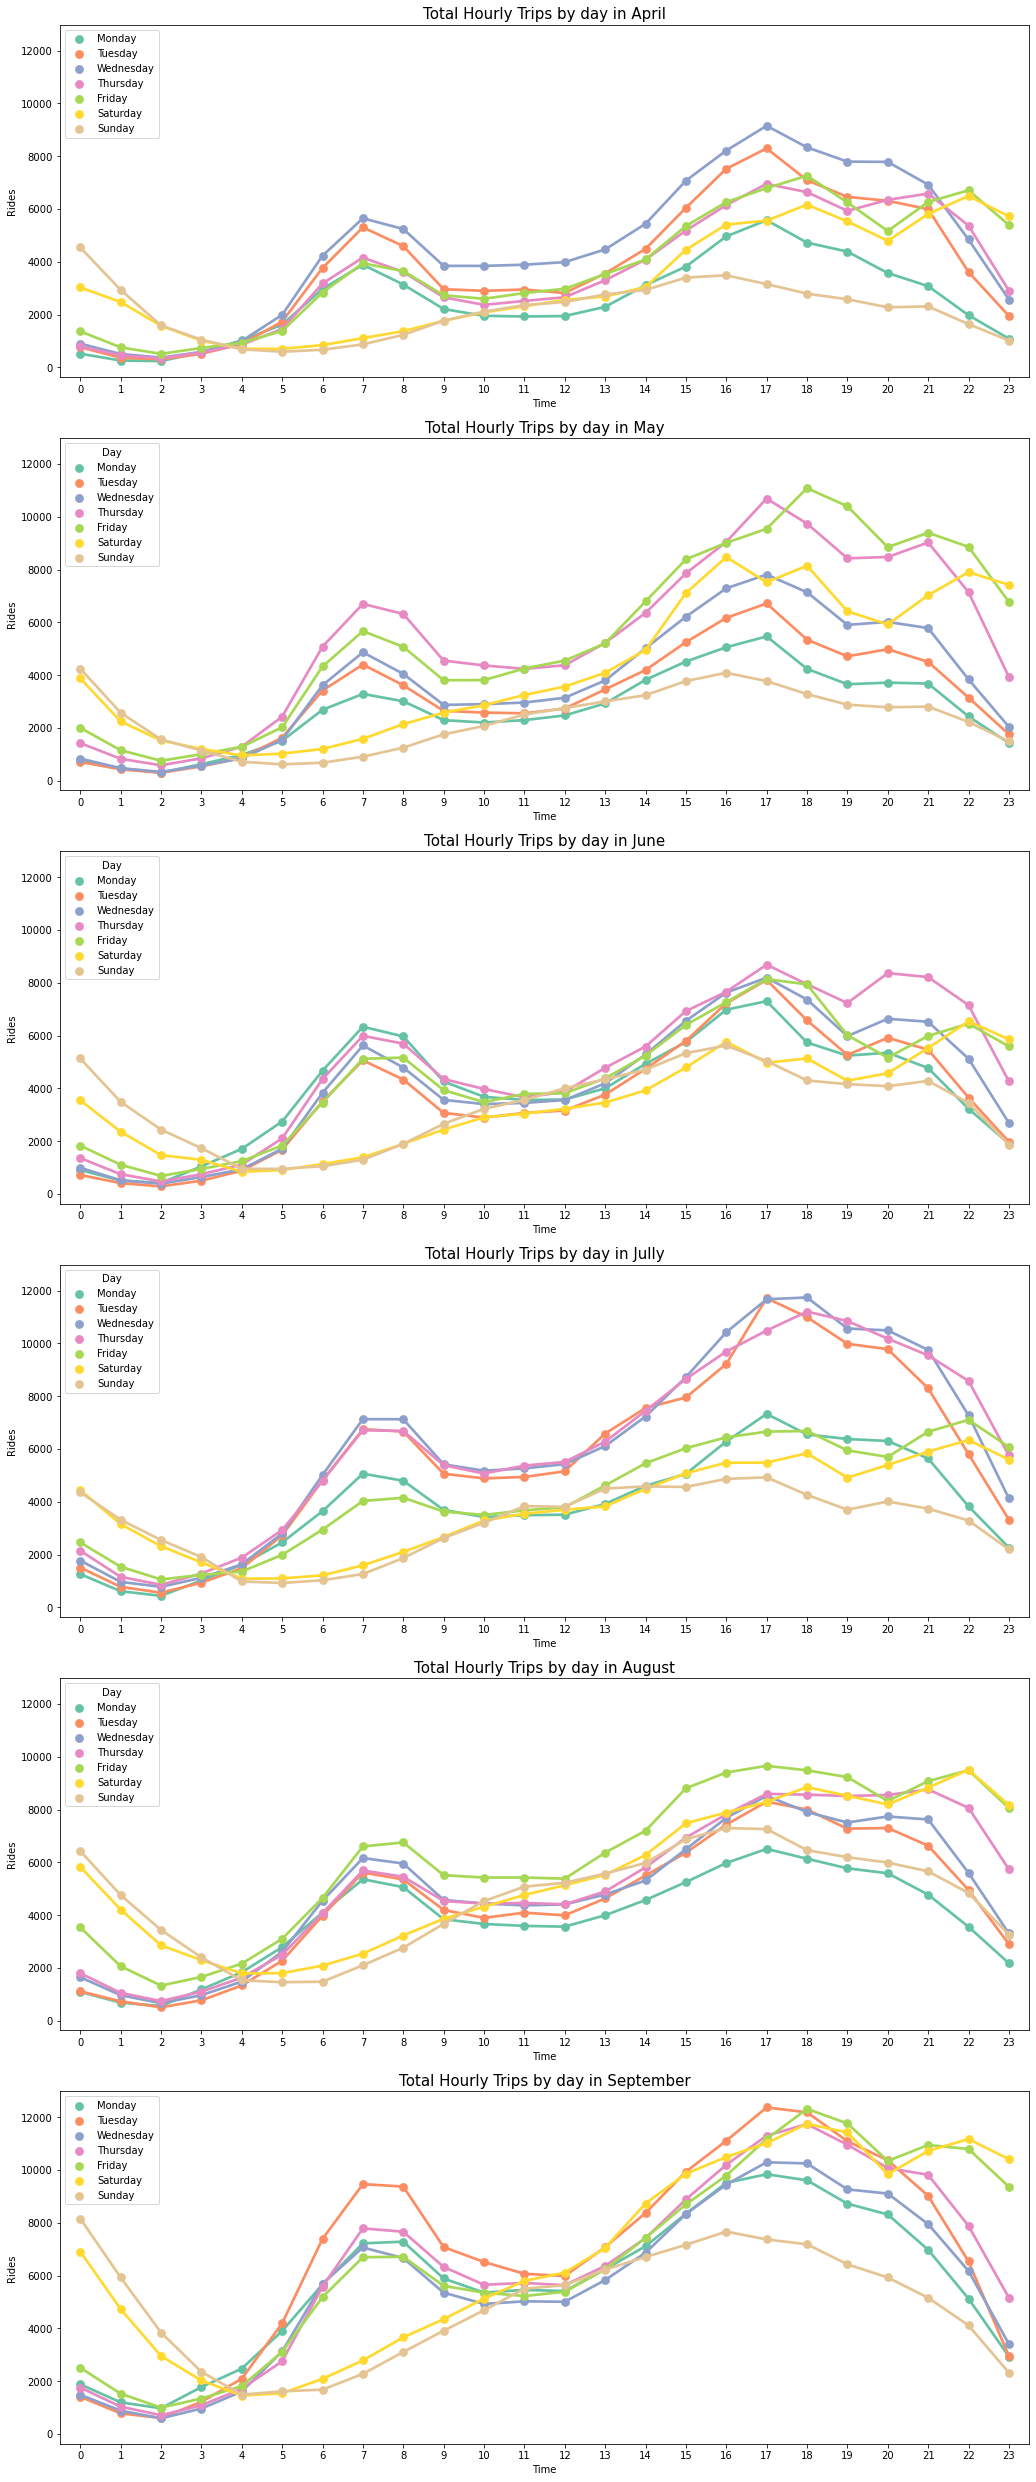

<Figure size 432x432 with 0 Axes>

In [16]:
# Seperate hourly dataset per month

apr_hourly = hourly_rides[hourly_rides.Month == 4]
may_hourly = hourly_rides[hourly_rides.Month == 5]
jun_hourly = hourly_rides[hourly_rides.Month == 6]
jul_hourly = hourly_rides[hourly_rides.Month == 7]
aug_hourly = hourly_rides[hourly_rides.Month == 8]
sep_hourly = hourly_rides[hourly_rides.Month == 9]


fig, axes = plt.subplots(6, 1, figsize=(15, 35), sharey=True)
plt.figure(figsize=(6,6))
fig.tight_layout(pad=4.0)

# April
sns.pointplot(ax=axes[0], x = 'Time', y = 'Rides', hue = 'Day', data = 
                          apr_hourly, palette='Set2')
axes[0].set_title('Total Hourly Trips by day in April', fontsize=15)
axes[0].legend(loc='upper left')

# May
sns.pointplot(ax=axes[1], x = 'Time', y = 'Rides', hue = 'Day', data = 
                          may_hourly, palette='Set2')
axes[1].set_title('Total Hourly Trips by day in May', fontsize=15)


# June
sns.pointplot(ax=axes[2], x = 'Time', y = 'Rides', hue = 'Day', data = 
                          jun_hourly, palette='Set2')
axes[2].set_title('Total Hourly Trips by day in June', fontsize=15)

# Jully
sns.pointplot(ax=axes[3], x = 'Time', y = 'Rides', hue = 'Day', data = 
                          jul_hourly, palette='Set2')
axes[3].set_title('Total Hourly Trips by day in Jully', fontsize=15)

# August
sns.pointplot(ax=axes[4], x = 'Time', y = 'Rides', hue = 'Day', data = 
                          aug_hourly, palette='Set2')
axes[4].set_title('Total Hourly Trips by day in August', fontsize=15)

# September
sns.pointplot(ax=axes[5], x = 'Time', y = 'Rides', hue = 'Day', data = 
                          sep_hourly, palette='Set2')
axes[5].set_title('Total Hourly Trips by day in September', fontsize=15)
axes[5].legend(loc='upper left')

plt.show()

The month-hour plots follow the same pattern. For the weekdays the higher picks appeared from 6:00 to 9:00 and from 17:00 to 21:00. At the weekends we notice the highest demand from 22:00 to midnight. Later there is a decrease in demand which starts to increase again after 12:00.